In [1]:
import os, math, time, random, re, types
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

PIVOTED_FILE = 'pivoted_data.parquet'             
ANOMALY_WINDOWS_FILE = 'anomaly_windows.csv'    
OUT_DIR = 'userData/pivoted_paper_autoformer_tf'
os.makedirs(OUT_DIR, exist_ok=True)

WIN_SIZE = 100         
BATCH_SIZE = 64
NUM_EPOCHS = 20
LR = 1e-4
PAPER_THR = 0.9973      


ROUND_RES = "5T"
EVENT_GAP_MINUTES = 15
PCT_PROB = 0.05

In [3]:
def read_parquet_smart(path, time_col='interval_start'):
    df = pd.read_parquet(path) if str(path).endswith('.parquet') else pd.read_csv(path)
    if time_col in df.columns and not isinstance(df.index, pd.DatetimeIndex):
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df = df.sort_values(time_col).set_index(time_col)
   
    if isinstance(df.index, pd.DatetimeIndex) and df.index.year.max() < 1990:
        ns = df.index.view('int64')
        maxv = float(ns.max())
        if maxv < 1e12:
            scale = 1_000_000_000
        elif maxv < 1e15:
            scale = 1_000_000
        elif maxv < 1e18:
            scale = 1_000
        else:
            scale = 1
        df = df.copy()
        df.index = pd.to_datetime(ns * scale, unit='ns')
    return df

def add_time_features(index):
    if not isinstance(index, pd.DatetimeIndex):
        index = pd.to_datetime(index, errors='coerce')
    ts_seconds = index.asi8 // 10**9
    day = 24 * 3600
    week = 7 * day
    return pd.DataFrame({
        'sin_day': np.sin(2 * np.pi * (ts_seconds % day) / day),
        'cos_day': np.cos(2 * np.pi * (ts_seconds % day) / day),
        'sin_week': np.sin(2 * np.pi * (ts_seconds % week) / week),
        'cos_week': np.cos(2 * np.pi * (ts_seconds % week) / week),
    }, index=index).astype(np.float32)

def make_sequences(df_values, L=1):
    arr = df_values.values
    if L == 1:
        return arr[:, None, :]
    n = len(arr) - L + 1
    return np.stack([arr[i:i+L] for i in range(n)], axis=0)

In [4]:
NAB_PROFILES = {
    "standard": {"TP": 1.0, "FN": -1.0, "FP": -0.11, "TN": 0.0},
    "low_fp":  {"TP": 1.0, "FN": -1.0, "FP": -0.22, "TN": 0.0},
    "low_fn": {"TP": 1.0, "FN": -2.0, "FP": -0.11, "TN": 0.0}
}

def scaled_sigmoid(x, lo, hi, slope=5.0):
    v = 1.0 / (1.0 + np.exp(-slope * x))
    return lo + (hi - lo) * v

def tp_score(time_hit, start, end, tp_weight):
    time_hit = pd.Timestamp(time_hit)
    start = pd.Timestamp(start)
    end = pd.Timestamp(end)
    L = (end - start).total_seconds()
    if L <= 0:
        return float(tp_weight)
    if time_hit <= start + pd.Timedelta(microseconds=1):
        return float(tp_weight)
    r = (time_hit - start).total_seconds() / L
    r = np.clip(r, 0.0, 1.0)
    x = 1.0 - 2.0 * r
    return float(scaled_sigmoid(x, 0.0, float(tp_weight)))

def fp_penalty(time_hit, windows, fp_weight):
    if not windows:
        return float(fp_weight)
    dists = []
    lens = []
    for (s, e) in windows:
        if s <= time_hit <= e:
            dists.append(0.0)
        elif time_hit < s:
            dists.append((s - time_hit).total_seconds())
        else:
            dists.append((time_hit - e).total_seconds())
        lens.append((e - s).total_seconds())
    d = float(min(dists))
    mean_len = float(np.mean(lens)) if len(lens) > 0 else 60.0
    z = d / max(mean_len, 1.0)
    val = scaled_sigmoid(z, float(fp_weight), 0.0)
    return float(min(0.0, val))

def read_gt_windows(csv_path, start_hint="start", end_hint="end"):
    gt = pd.read_csv(csv_path)
    s_cols = [c for c in gt.columns if start_hint in c.lower()]
    e_cols = [c for c in gt.columns if end_hint in c.lower()]
    if not s_cols or not e_cols:
        raise ValueError("Could not find start/end columns in anomaly_windows.csv")
    s_col = s_cols[0]
    e_col = e_cols[0]
    df = pd.DataFrame({
        "anomaly_start": pd.to_datetime(gt[s_col].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors="coerce"),
        "anomaly_end":   pd.to_datetime(gt[e_col].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors="coerce")
    }).dropna().reset_index(drop=True)
    return df

def mask_to_event_times(pred_mask, timestamps, event_gap_minutes=15, pct_prob=0.0):
    timestamps = np.asarray(timestamps)
    pm = np.asarray(pred_mask).astype(bool)
    if pct_prob > 0.0:
        cutoff = timestamps[0] + (timestamps[-1] - timestamps[0]) * pct_prob
        pm = pm & (timestamps >= cutoff)
    if not pm.any():
        return []
    shifted = np.concatenate(([False], pm[:-1]))
    edges = np.where(pm & (~shifted))[0]
    if len(edges) == 0:
        edges = np.array([np.where(pm)[0][0]])
    events = [pd.to_datetime(timestamps[edges[0]])]
    gap = pd.Timedelta(minutes=event_gap_minutes)
    for idx in edges[1:]:
        t = pd.to_datetime(timestamps[idx])
        if (t - events[-1]) >= gap:
            events.append(t)
    return events

def nab_score_from_mask(pred_mask, gt_windows_df, timestamps, profile="standard", event_gap_minutes=15, pct_prob=0.0):
    if profile not in NAB_PROFILES:
        raise ValueError("Unknown NAB profile: " + str(profile))
    prof = NAB_PROFILES[profile]
    TPw, FNw, FPw = prof["TP"], prof["FN"], prof["FP"]
    wins = [(pd.Timestamp(r["anomaly_start"]), pd.Timestamp(r["anomaly_end"])) for _, r in gt_windows_df.iterrows()]
    events = mask_to_event_times(pred_mask, timestamps, event_gap_minutes, pct_prob)
    score = 0.0
    TP = 0
    FP = 0
    used = [False] * len(wins)
    for ev in events:
        hit = -1
        for i, (s, e) in enumerate(wins):
            if (not used[i]) and (s <= ev <= e):
                hit = i
                break
        if hit >= 0:
            score += tp_score(ev, wins[hit][0], wins[hit][1], TPw)
            used[hit] = True
            TP += 1
        else:
            score += fp_penalty(ev, wins, FPw)
            FP += 1
    FN = sum(not u for u in used)
    score += FNw * FN
    perfect = TPw * len(wins)
    null = FNw * len(wins)
    if np.isclose(perfect, null):
        normalized = 0.0
    else:
        normalized = 100.0 * (score - null) / (perfect - null)
    return float(normalized), {"TP": int(TP), "FN": int(FN), "FP": int(FP)}

def likelihood_scores_from_s(err, W=30, Wp=2):
    T = len(err)
    L = np.zeros(T)
    eps = 1e-8
    for t in range(T):
        a = max(0, t - W + 1)
        b = t + 1
        a2 = max(0, t - Wp + 1)
        long_window = err[a:b]
        short_window = err[a2:b]
        mu = long_window.mean()
        std = long_window.std(ddof=1) if (b - a) > 1 else eps
        mu_s = short_window.mean()
        z = (mu_s - mu) / (std + eps)
        L[t] = norm.cdf(z)
    return L

In [5]:

print('Loading data from:', PIVOTED_FILE)
df = read_parquet_smart(PIVOTED_FILE, time_col='interval_start')

Loading data from: pivoted_data.parquet


In [6]:
include_patterns = [r'(5xx|_5\d\d_)', r'_count$']
compiled = [re.compile(p, re.I) for p in include_patterns]
feature_cols = [c for c in df.columns if all(p.search(c) for p in compiled)]
print('Selected feature columns:', len(feature_cols))
if len(feature_cols) == 0:
    raise ValueError('No features matched the selection patterns.')

five_xx_cols = [c for c in df.columns if re.search(r'5xx|_5\d\d_', c, re.I) and c.endswith('_count')]
df['sum_5xx_count'] = df[five_xx_cols].fillna(0).sum(axis=1)

Selected feature columns: 2406


In [7]:
X = df[feature_cols].fillna(0).astype(np.float32)
X = pd.concat([X, add_time_features(X.index)], axis=1)

TRAIN_START, TRAIN_END = pd.Timestamp('2024-01-26'), pd.Timestamp('2024-02-29 23:59:59')
TEST_START, TEST_END = pd.Timestamp('2024-03-01'), pd.Timestamp('2024-05-31 23:59:59')

train_df = X[(X.index >= TRAIN_START) & (X.index <= TRAIN_END)].copy()
test_df  = X[(X.index >= TEST_START) & (X.index <= TEST_END)].copy()
print('Train rows:', len(train_df), 'Test rows:', len(test_df))

Train rows: 10074 Test rows: 26487


In [8]:

gt_all = pd.read_csv(ANOMALY_WINDOWS_FILE)
s_cols = [c for c in gt_all.columns if 'start' in c.lower()]
e_cols = [c for c in gt_all.columns if 'end' in c.lower()]
if not s_cols or not e_cols:
    raise ValueError('Could not find start/end columns in anomaly_windows.csv')
gt_df_raw = pd.DataFrame({
    'anomaly_start': pd.to_datetime(gt_all[s_cols[0]].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors='coerce'),
    'anomaly_end':   pd.to_datetime(gt_all[e_cols[0]].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors='coerce')
}).dropna().reset_index(drop=True)

gt_in_test = gt_df_raw[(gt_df_raw['anomaly_end'] >= test_df.index[0]) & (gt_df_raw['anomaly_start'] <= test_df.index[-1])].reset_index(drop=True)
print('GT windows total:', len(gt_df_raw), 'GT inside test:', len(gt_in_test))

GT windows total: 25 GT inside test: 18


In [9]:
mask_train_anomalies = True
if mask_train_anomalies:
    train_idx = train_df.index
    keep_mask = np.ones(len(train_idx), dtype=bool)
    for s, e in gt_df_raw.itertuples(index=False):
        keep_mask &= ~((train_idx >= s) & (train_idx <= e))
    removed = len(train_df) - keep_mask.sum()
    train_df = train_df.loc[keep_mask]
    print('Rows removed from training due to masking GT windows:', removed)
    

Rows removed from training due to masking GT windows: 100


In [10]:
scaler = MinMaxScaler()
scaler.fit(train_df)
train_scaled = pd.DataFrame(scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
test_scaled = pd.DataFrame(scaler.transform(test_df), index=test_df.index, columns=test_df.columns)

def sliding_windows_from_df(df_scaled, win_size, stride=1):
    arr = df_scaled.values
    n = len(arr)
    if n < win_size:
        return np.zeros((0, win_size, arr.shape[1])), np.zeros((0,)), []
    Xw = []
    ts = []
    for i in range(0, n - win_size + 1, stride):
        Xw.append(arr[i:i+win_size])
        ts.append(df_scaled.index[i+win_size-1])  # align to last timestamp
    return np.stack(Xw, axis=0), np.zeros((len(Xw),), dtype=int), ts

win_size = WIN_SIZE
Xtr_w, ytr_w, tr_ts = sliding_windows_from_df(train_scaled, win_size)
Xte_w, yte_w, te_ts = sliding_windows_from_df(test_scaled, win_size)

print('Train windows:', Xtr_w.shape, 'Test windows:', Xte_w.shape)

Train windows: (9875, 100, 2410) Test windows: (26388, 100, 2410)


In [11]:
try:
    AUTOTUNE = tf.data.AUTOTUNE
except AttributeError:
    try:
        AUTOTUNE = tf.data.experimental.AUTOTUNE
    except AttributeError:
        AUTOTUNE = 1

In [12]:

Xtr = Xtr_w.astype('float32')
Xte = Xte_w.astype('float32')

train_ds = tf.data.Dataset.from_tensor_slices((Xtr, Xtr))
train_ds = train_ds.shuffle(2048, seed=SEED).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((Xte, Xte))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("tf version:", tf.__version__, "using AUTOTUNE =", AUTOTUNE)


tf version: 2.0.0 using AUTOTUNE = -1


In [13]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = np.zeros((max_len, d_model), dtype=np.float32)
        position = np.arange(max_len)[:, None]
        div_term = np.exp(np.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = tf.constant(pe[None, :, :], dtype=tf.float32)
    def call(self, x):
        L = tf.shape(x)[1]
        return tf.cast(self.pe[:, :L, :], x.dtype)

class TokenEmbedding(layers.Layer):
    def __init__(self, c_in, d_model):
        super().__init__()
        self.conv = layers.Conv1D(filters=d_model, kernel_size=3, padding='same', activation=None)
    def call(self, x):
        return self.conv(x)

class TemporalEmbedding(layers.Layer):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super().__init__()
        self.proj = layers.Dense(d_model)
    def call(self, x_mark):
        if x_mark is None:
            return 0.0
        return self.proj(x_mark)

class DataEmbedding_wo_pos(layers.Layer):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super().__init__()
        self.value_embedding = TokenEmbedding(c_in, d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type, freq=freq) if True else None
        self.dropout = layers.Dropout(dropout)
    def call(self, x, x_mark=None, training=False):
        if x_mark is None:
            x = self.value_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(x_mark)
        return self.dropout(x, training=training)

class DataEmbedding(layers.Layer):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super().__init__()
        self.value_embedding = TokenEmbedding(c_in, d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = layers.Dropout(dropout)
    def call(self, x, x_mark=None, training=False):
        if x_mark is None:
            emb = self.value_embedding(x) + self.position_embedding(x)
        else:
            emb = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(emb, training=training)

class MovingAvg(layers.Layer):
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2

    def call(self, x):
       
        left = x[:, :1, :]                         
        right = x[:, -1:, :]                      
        pad_left = tf.tile(left, [1, self.padding, 1])  
        pad_right = tf.tile(right, [1, self.padding, 1]) 
        x_p = tf.concat([pad_left, x, pad_right], axis=1) 

        kernel = tf.ones((self.kernel_size, 1, 1), dtype=x.dtype) / tf.cast(self.kernel_size, x.dtype)
        B = tf.shape(x_p)[0]; Lp = tf.shape(x_p)[1]; C = tf.shape(x_p)[2]

       
        x_resh = tf.reshape(x_p, (B * C, Lp, 1))
        kernel_tf = tf.reshape(kernel, (self.kernel_size, 1, 1))
        out = tf.nn.conv1d(x_resh, filters=kernel_tf, stride=1, padding='VALID') 
        out = tf.reshape(out, (B, C, -1))  # (B, C, L)
        out = tf.transpose(out, perm=[0, 2, 1])  # (B, L, C)
        return out


class SeriesDecomp(layers.Layer):
    def __init__(self, kernel_size):
        super().__init__()
        self.mavg = MovingAvg(kernel_size)
    def call(self, x):
        trend = self.mavg(x)
        resid = x - trend
        return resid, trend

class AutoCorrelationInner(layers.Layer):
    def __init__(self, mask_flag=True, factor=1, attention_dropout=0.1, output_attention=False):
        super().__init__()
        self.factor = factor
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = layers.Dropout(attention_dropout)
    def time_delay_agg_training(self, values, corr):
        
        length = tf.shape(values)[-1]
        
        top_k = tf.maximum(1, tf.cast(tf.math.floor(self.factor * tf.math.log(tf.cast(length, tf.float32))), tf.int32))
      
        mean_value = tf.reduce_mean(tf.reduce_mean(corr, axis=1), axis=1)  
        
        vals, idx = tf.math.top_k(mean_value, k=top_k)  
        weights = tf.nn.softmax(vals, axis=-1)           

        B = tf.shape(values)[0]
        delays_agg = tf.zeros_like(values)

        
        i0 = tf.constant(0, dtype=tf.int32)

        def cond(i, delays_agg):
            return tf.less(i, top_k)

        def body(i, delays_agg):
            
            shifts = tf.gather(idx, i, axis=1)  
          
            def roll_one(args):
                v, s = args
                return tf.roll(v, shift=-s, axis=-1)
            rolled = tf.map_fn(lambda z: roll_one(z), (values, shifts), dtype=values.dtype)
            w = tf.reshape(tf.gather(weights, i, axis=1), (B, 1, 1, 1))
            delays_agg = delays_agg + rolled * w
            return i + 1, delays_agg

        _, delays_agg = tf.while_loop(cond, body, loop_vars=[i0, delays_agg], parallel_iterations=1)
        return delays_agg

    def time_delay_agg_inference(self, values, corr):
        
        length = tf.shape(values)[-1]
        top_k = tf.maximum(1, tf.cast(tf.math.floor(self.factor * tf.math.log(tf.cast(length, tf.float32))), tf.int32))
        mean_value = tf.reduce_mean(tf.reduce_mean(corr, axis=1), axis=1)  
        vals, delay = tf.math.top_k(mean_value, k=top_k)  
        weights = tf.nn.softmax(vals, axis=-1)            

        B = tf.shape(values)[0]
        delays_agg = tf.zeros_like(values)
        i0 = tf.constant(0, dtype=tf.int32)

        def cond(i, delays_agg):
            return tf.less(i, top_k)

        def body(i, delays_agg):
            d = tf.gather(delay, i, axis=1)  
            def roll_one(args):
                v, s = args
                return tf.roll(v, shift=-s, axis=-1)
            gathered = tf.map_fn(lambda z: roll_one(z), (values, d), dtype=values.dtype)
            w = tf.reshape(tf.gather(weights, i, axis=1), (B, 1, 1, 1))
            delays_agg = delays_agg + gathered * w
            return i + 1, delays_agg

        _, delays_agg = tf.while_loop(cond, body, loop_vars=[i0, delays_agg], parallel_iterations=1)
        return delays_agg

    def call(self, queries, keys, values, training=True):
        
        qf = tf.signal.rfft(queries)
        kf = tf.signal.rfft(keys)
        res = qf * tf.math.conj(kf)

        length = tf.shape(queries)[-1]
        corr = tf.signal.irfft(res, fft_length=[length])

        if training:
            V = self.time_delay_agg_training(values, corr)
        else:
            V = self.time_delay_agg_inference(values, corr)

        if self.output_attention:
            return V, corr
        else:
            return V, None


class AutoCorrelationLayerK(layers.Layer):
   
    def __init__(self, correlation_module, d_model, n_heads, d_keys=None, d_values=None):
        super().__init__()
        self.inner = correlation_module
        self.n_heads = n_heads
       
        self.d_keys = d_keys or (d_model // n_heads)
        self.d_values = d_values or (d_model // n_heads)
        
        self.q_proj = layers.Dense(self.d_keys * n_heads, use_bias=True)
        self.k_proj = layers.Dense(self.d_keys * n_heads, use_bias=True)
        self.v_proj = layers.Dense(self.d_values * n_heads, use_bias=True)
        
        self.out_dim_in = int(self.n_heads * self.d_values)
        self.out_dim_out = int(d_model)
        
        self.out_proj_w = self.add_weight(
            name='out_proj_w',
            shape=(self.out_dim_in, self.out_dim_out),
            initializer=keras.initializers.glorot_uniform(),
            trainable=True,
            dtype=tf.float32
        )
       
        self.out_proj_b = self.add_weight(
            name='out_proj_b',
            shape=(self.out_dim_out,),
            initializer='zeros',
            trainable=True,
            dtype=tf.float32
        )

    def call(self, queries, keys, values, attn_mask=None, training=False):
      
        B = tf.shape(queries)[0]; L = tf.shape(queries)[1]
        S = tf.shape(keys)[1]
        H = self.n_heads

       
        q = self.q_proj(queries)  
        k = self.k_proj(keys)    
        v = self.v_proj(values)  

        
        q = tf.reshape(q, (B, L, H, -1))
        k = tf.reshape(k, (B, S, H, -1))
        v = tf.reshape(v, (B, S, H, -1))

        
        q_inner = tf.transpose(q, perm=[0,2,3,1]) 
        k_inner = tf.transpose(k, perm=[0,2,3,1])  
        v_inner = tf.transpose(v, perm=[0,2,3,1]) 

        out, attn = self.inner(q_inner, k_inner, v_inner, training=training)
       
        out = tf.transpose(out, perm=[0,3,1,2])
     
        out = tf.reshape(out, (B, L, -1))  

       
        projected = tf.tensordot(out, self.out_proj_w, axes=[[2], [0]]) 
        projected = projected + self.out_proj_b 
        return projected, attn


class MyLayerNorm(layers.Layer):
    def __init__(self, channels):
        super().__init__()
        self.ln = layers.LayerNormalization(axis=-1, epsilon=1e-6)
    def call(self, x):
        x_hat = self.ln(x)
        bias = tf.reduce_mean(x_hat, axis=1, keepdims=True)
        return x_hat - bias


class EncoderLayerK(layers.Layer):
    def __init__(self, attention_layer, d_model, d_ff=None, moving_avg=25, dropout=0.1, activation='relu'):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention_layer
        
        self.conv1 = layers.Conv1D(filters=d_ff, kernel_size=1, use_bias=False)
        self.conv2 = layers.Conv1D(filters=d_model, kernel_size=1, use_bias=False)
        self.decomp1 = SeriesDecomp(moving_avg)
        self.decomp2 = SeriesDecomp(moving_avg)
        self.dropout = layers.Dropout(dropout)
        self.activation = tf.nn.relu if activation == 'relu' else tf.nn.gelu

    def call(self, x, attn_mask=None, training=False):
        # x: (B, L, D)
        new_x, attn = self.attention(x, x, x, attn_mask, training=training)
        x = x + self.dropout(new_x, training=training)
        x, _ = self.decomp1(x)
        y = x
       
        y = self.dropout(self.activation(self.conv1(y)), training=training) 
        y = self.dropout(self.conv2(y), training=training)                  
        res, _ = self.decomp2(x + y)
        return res, attn


class EncoderK(layers.Layer):
    def __init__(self, attn_layers, norm_layer=None):
        super().__init__()
        self.attn_layers = attn_layers
        self.norm = norm_layer
    def call(self, x, attn_mask=None, training=False):
        attns = []
        for layer in self.attn_layers:
            x, attn = layer(x, attn_mask=attn_mask, training=training)
            attns.append(attn)
        if self.norm is not None:
            x = self.norm(x)
        return x, attns

class DecoderLayerK(layers.Layer):
    def __init__(self, self_attention, cross_attention, d_model, c_out, d_ff=None, moving_avg=25, dropout=0.1, activation='relu'):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        
        self.conv1 = layers.Conv1D(filters=d_ff, kernel_size=1, use_bias=False)
        self.conv2 = layers.Conv1D(filters=d_model, kernel_size=1, use_bias=False)
        self.decomp1 = SeriesDecomp(moving_avg)
        self.decomp2 = SeriesDecomp(moving_avg)
        self.decomp3 = SeriesDecomp(moving_avg)
        self.dropout = layers.Dropout(dropout)
        
        self.proj_conv = layers.Conv1D(filters=c_out, kernel_size=3, padding='same')
        self.activation = tf.nn.relu if activation == 'relu' else tf.nn.gelu

    def call(self, x, cross, x_mask=None, cross_mask=None, training=False):
       
        x = x + self.dropout(self.self_attention(x, x, x, x_mask, training=training)[0], training=training)
        x, trend1 = self.decomp1(x)
        
        x = x + self.dropout(self.cross_attention(x, cross, cross, cross_mask, training=training)[0], training=training)
        x, trend2 = self.decomp2(x)
        y = x
        
        y = self.dropout(self.activation(self.conv1(y)), training=training)  
        y = self.dropout(self.conv2(y), training=training)                  
        x, trend3 = self.decomp3(x + y)
        residual_trend = trend1 + trend2 + trend3  
        
        residual_trend_proj = self.proj_conv(residual_trend) 
        return x, residual_trend_proj

class DecoderK(layers.Layer):
    def __init__(self, layers_list, norm_layer=None, projection=None):
        super().__init__()
        self.layers = layers_list
        self.norm = norm_layer
        self.projection = projection
    def call(self, x, cross, x_mask=None, cross_mask=None, trend=None, training=False):
        for layer in self.layers:
            x, residual_trend = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, training=training)
            trend = trend + residual_trend
        if self.norm is not None:
            x = self.norm(x)
        if self.projection is not None:
            x = self.projection(x)
        return x, trend

class AutoformerKerasModel(keras.Model):
    def __init__(self, configs):
        super().__init__()
        self.task_name = configs.task_name
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len
        kernel_size = getattr(configs, 'moving_avg', 25)
        self.decomp = SeriesDecomp(kernel_size)
        self.enc_embedding = DataEmbedding_wo_pos(configs.enc_in, configs.d_model, configs.embed, configs.freq, configs.dropout)
        if self.task_name in ('long_term_forecast', 'short_term_forecast'):
            self.dec_embedding = DataEmbedding_wo_pos(configs.dec_in, configs.d_model, configs.embed, configs.freq, configs.dropout)
        enc_layers = []
        for _ in range(configs.e_layers):
            autocorr = AutoCorrelationInner(mask_flag=False, factor=configs.factor, attention_dropout=configs.dropout, output_attention=False)
            ac_layer = AutoCorrelationLayerK(autocorr, configs.d_model, configs.n_heads)
            enc_layers.append(EncoderLayerK(ac_layer, configs.d_model, configs.d_ff, moving_avg=kernel_size, dropout=configs.dropout, activation=configs.activation))
        self.encoder = EncoderK(enc_layers, norm_layer=MyLayerNorm(configs.d_model))
        if self.task_name in ('long_term_forecast', 'short_term_forecast'):
            dec_layers = []
            for _ in range(configs.d_layers):
                self_att = AutoCorrelationLayerK(AutoCorrelationInner(mask_flag=True, factor=configs.factor, attention_dropout=configs.dropout, output_attention=False), configs.d_model, configs.n_heads)
                cross_att = AutoCorrelationLayerK(AutoCorrelationInner(mask_flag=False, factor=configs.factor, attention_dropout=configs.dropout, output_attention=False), configs.d_model, configs.n_heads)
                dec_layers.append(DecoderLayerK(self_att, cross_att, configs.d_model, configs.c_out, configs.d_ff, moving_avg=kernel_size, dropout=configs.dropout, activation=configs.activation))
            proj = layers.Dense(configs.c_out)
            self.decoder = DecoderK(dec_layers, norm_layer=MyLayerNorm(configs.d_model), projection=proj)
        if self.task_name in ('imputation', 'anomaly_detection'):
            self.projection = layers.Dense(configs.c_out)
        if self.task_name == 'classification':
            self.act = tf.nn.gelu
            self.dropout = layers.Dropout(configs.dropout)
            self.projection = layers.Dense(configs.num_class)

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec, training=False):
        mean = tf.reduce_mean(x_enc, axis=1, keepdims=True)
        mean = tf.tile(mean, [1, self.pred_len, 1])
        zeros = tf.zeros([tf.shape(x_enc)[0], self.pred_len, tf.shape(x_enc)[2]], dtype=x_enc.dtype)
        seasonal_init, trend_init = self.decomp(x_enc)
        trend_init = tf.concat([trend_init[:, -self.label_len:, :], mean], axis=1)
        seasonal_init = tf.concat([seasonal_init[:, -self.label_len:, :], zeros], axis=1)
        enc_out = self.enc_embedding(x_enc, x_mark_enc, training=training)
        enc_out, attns = self.encoder(enc_out, attn_mask=None, training=training)
        dec_out = self.dec_embedding(seasonal_init, x_mark_dec, training=training)
        seasonal_part, trend_part = self.decoder(dec_out, enc_out, x_mask=None, cross_mask=None, trend=trend_init, training=training)
        dec_out = seasonal_part + trend_part
        return dec_out

    def imputation(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None, training=False):
        enc_out = self.enc_embedding(x_enc, x_mark_enc, training=training)
        enc_out, attns = self.encoder(enc_out, attn_mask=None, training=training)
        dec_out = self.projection(enc_out)
        return dec_out

    def anomaly_detection(self, x_enc, training=False):
        enc_out = self.enc_embedding(x_enc, None, training=training)
        enc_out, attns = self.encoder(enc_out, attn_mask=None, training=training)
        dec_out = self.projection(enc_out)
        return dec_out

    def classification(self, x_enc, x_mark_enc, training=False):
        enc_out = self.enc_embedding(x_enc, x_mark_enc, training=training)
        enc_out, attns = self.encoder(enc_out, attn_mask=None, training=training)
        output = self.act(enc_out)
        output = self.dropout(output, training=training)
        if x_mark_enc is not None:
            output = output * tf.expand_dims(x_mark_enc, -1)
        output = tf.reshape(output, (tf.shape(output)[0], -1))
        output = self.projection(output)
        return output

    def call(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None, mask=None, training=False):
        if self.task_name in ('long_term_forecast', 'short_term_forecast'):
            dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec, training=training)
            return dec_out[:, -self.pred_len:, :]
        if self.task_name == 'imputation':
            return self.imputation(x_enc, x_mark_enc, x_dec, x_mark_dec, mask=mask, training=training)
        if self.task_name == 'anomaly_detection':
            return self.anomaly_detection(x_enc, training=training)
        if self.task_name == 'classification':
            return self.classification(x_enc, x_mark_enc, training=training)
        return None
    

In [14]:
cfg = types.SimpleNamespace()
cfg.task_name = 'anomaly_detection'
cfg.seq_len = WIN_SIZE
cfg.label_len = WIN_SIZE // 2
cfg.pred_len = 0
cfg.moving_avg = 25
cfg.enc_in = Xtr_w.shape[-1]
cfg.dec_in = Xtr_w.shape[-1]
cfg.d_model = 64
cfg.n_heads = 4
cfg.d_ff = 256
cfg.e_layers = 3
cfg.d_layers = 2
cfg.c_out = Xtr_w.shape[-1]
cfg.factor = 1
cfg.dropout = 0.05
cfg.embed = 'fixed'
cfg.freq = 'h'
cfg.activation = 'relu'
cfg.num_class = 2
model = AutoformerKerasModel(cfg)
model.build(input_shape=(None, WIN_SIZE, cfg.enc_in))  
_ = model(tf.zeros((1, WIN_SIZE, cfg.enc_in)), training=False) 
model.compile(optimizer=keras.optimizers.Adam(LR), loss='mse')
best_path = os.path.join(OUT_DIR, 'autoformer_ae_checkpoint.tf')

In [15]:

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(best_path, save_weights_only=True, save_best_only=False)
print('Starting training...')
history = model.fit(train_ds, epochs=NUM_EPOCHS, validation_data=None, callbacks=[checkpoint_cb], verbose=1)
print('Training finished. checkpoint saved to', best_path)

Starting training...
Epoch 1/20
155/155 [==============================] - 672s 4s/step - loss: 0.0041
Epoch 2/20
155/155 [==============================] - 667s 4s/step - loss: 0.0021
Epoch 3/20
155/155 [==============================] - 666s 4s/step - loss: 0.0016
Epoch 4/20
155/155 [==============================] - 665s 4s/step - loss: 0.0014
Epoch 5/20
155/155 [==============================] - 666s 4s/step - loss: 0.0012
Epoch 6/20
155/155 [==============================] - 664s 4s/step - loss: 0.0012
Epoch 7/20
155/155 [==============================] - 666s 4s/step - loss: 0.0011
Epoch 8/20
155/155 [==============================] - 668s 4s/step - loss: 0.0011
Epoch 9/20
155/155 [==============================] - 670s 4s/step - loss: 0.0010
Epoch 10/20
155/155 [==============================] - 669s 4s/step - loss: 9.9397e-04
Epoch 11/20
155/155 [==============================] - 670s 4s/step - loss: 9.6817e-04
Epoch 12/20
155/155 [==============================] - 670s 4s/step

In [16]:
model.load_weights(best_path)

all_rec_err = []
for batch_x, _ in test_ds:
    batch_x = tf.cast(batch_x, tf.float32)
    output = model(batch_x, training=False)  
    loss = tf.reduce_mean(tf.square(output - batch_x), axis=[1,2]) 
    all_rec_err.append(loss.numpy())
all_rec_err = np.concatenate(all_rec_err, axis=0).reshape(-1)
print('Per-window reconstruction errors:', all_rec_err.shape)

Per-window reconstruction errors: (26388,)


In [17]:
timestamps = pd.to_datetime(te_ts)
minlen = min(len(all_rec_err), len(timestamps))
all_rec_err = all_rec_err[:minlen]
timestamps = timestamps[:minlen]

W_LONG = 30
W_SHORT = 2
L = likelihood_scores_from_s(all_rec_err, W=W_LONG, Wp=W_SHORT)
scores_df = pd.DataFrame({'timestamp': timestamps, 'anomaly_score': L}).set_index('timestamp')

pred_series = (scores_df['anomaly_score'] >= PAPER_THR).astype(int)

In [18]:
gt_df = gt_in_test.copy()
gt_df['anomaly_start'] = pd.to_datetime(gt_df['anomaly_start']).dt.tz_localize(None)
gt_df['anomaly_end'] = pd.to_datetime(gt_df['anomaly_end']).dt.tz_localize(None)
gt_df['start_rounded'] = gt_df['anomaly_start'].dt.round(ROUND_RES)
gt_df['end_rounded'] = gt_df['anomaly_end'].dt.round(ROUND_RES)
t0, t1 = timestamps[0], timestamps[-1]
gt_df['start_clipped'] = gt_df['start_rounded'].clip(lower=t0, upper=t1)
gt_df['end_clipped'] = gt_df['end_rounded'].clip(lower=t0, upper=t1)
gt_df = gt_df[gt_df['start_clipped'] <= gt_df['end_clipped']].reset_index(drop=True)

gt_series = pd.Series(0, index=timestamps)
for _, r in gt_df.iterrows():
    s, e = r['start_clipped'], r['end_clipped']
    mask = (gt_series.index >= s) & (gt_series.index <= e)
    if mask.any():
        gt_series.loc[mask] = 1

TP = int(((pred_series == 1) & (gt_series == 1)).sum())
FP = int(((pred_series == 1) & (gt_series == 0)).sum())
TN = int(((pred_series == 0) & (gt_series == 0)).sum())
FN = int(((pred_series == 0) & (gt_series == 1)).sum())
print('\nPer-timestamp counts:')
print(f'  TP={TP}  TN={TN}  FP={FP}  FN={FN}  total={len(pred_series)}')


Per-timestamp counts:
  TP=26  TN=25215  FP=304  FN=843  total=26388


In [22]:
norm_standard, counts_standard = nab_score_from_mask(pred_series.astype(bool), gt_df, timestamps, profile='standard')
norm_lowfn, counts_lowfn = nab_score_from_mask(pred_series.astype(bool), gt_df, timestamps, profile='low_fn')
print('\nWindow-based normalized NAB scores:')
print(f'  Standard: {norm_standard:.2f} | event-counts: {counts_standard}')
print(f'  Low-FN  : {norm_lowfn:.2f} | event-counts: {counts_lowfn}')



Window-based normalized NAB scores:
  Standard: 26.56 | event-counts: {'TP': 6, 'FN': 12, 'FP': 151}
  Low-FN  : 28.82 | event-counts: {'TP': 6, 'FN': 12, 'FP': 151}


In [23]:
ts_metrics = {
    "kind": "per_timestamp",
    "TP": TP_ts, "FP": FP_ts, "TN": TN_ts, "FN": FN_ts,
    "precision_pct": 100.0 * prec_ts, "recall_pct": 100.0 * rec_ts, "f1_pct": 100.0 * f1_ts,
    "total": total_ts
}


per_ts_path = os.path.join(OUT_DIR, f'per_timestamp_preds_thr_{str(PAPER_THR).replace(".","")}.csv')
scores_df.assign(pred=pred_series.values, gt=gt_series.values).to_csv(per_ts_path)
events = mask_to_event_times(pred_series.astype(bool), scores_df.index, event_gap_minutes=EVENT_GAP_MINUTES, pct_prob=0.0)
ev_df = pd.DataFrame({'alert_time': pd.to_datetime(events)})
ev_path = os.path.join(OUT_DIR, f'autoformer_alerts_thr_{str(PAPER_THR).replace(".","")}.csv')
ev_df.to_csv(ev_path, index=False)
print('\nSaved per-timestamp preds to:', per_ts_path)
print('Saved event alerts CSV to:', ev_path)


Saved per-timestamp preds to: userData/pivoted_paper_autoformer_tf/per_timestamp_preds_thr_09973.csv
Saved event alerts CSV to: userData/pivoted_paper_autoformer_tf/autoformer_alerts_thr_09973.csv


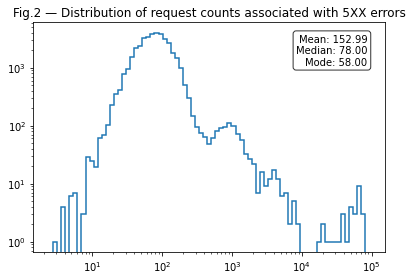

Saved Fig.2 -> userData/pivoted_paper_autoformer_tf/fig2_5xx_distribution_autoformer_gru_style.png


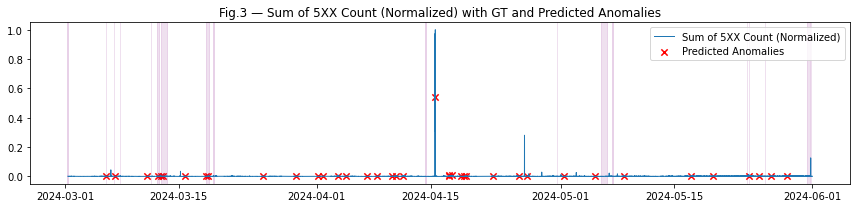

Saved Fig.3 -> userData/pivoted_paper_autoformer_tf/fig3_sum5xx_norm_with_alerts_autoformer.png


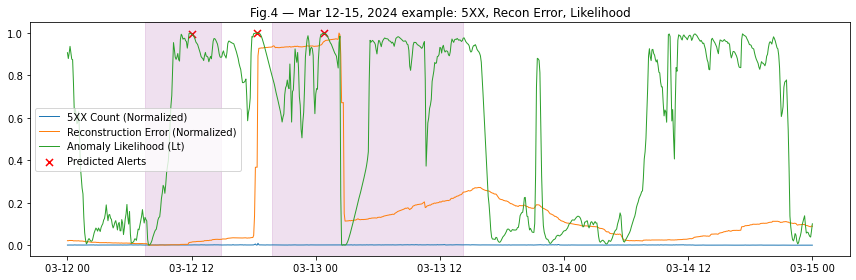

Saved Fig.4 -> userData/pivoted_paper_autoformer_tf/fig4_mar12_15_autoformer.png


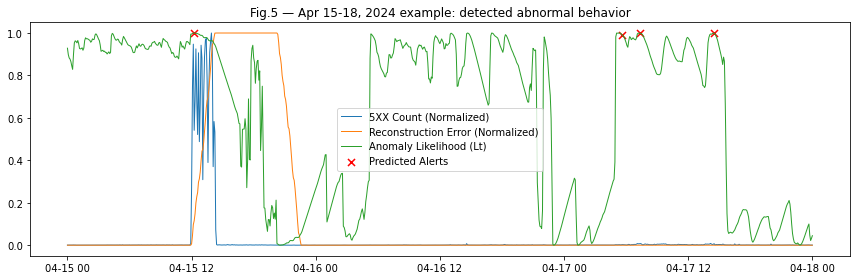

Saved Fig.5 -> userData/pivoted_paper_autoformer_tf/fig5_apr15_18_autoformer.png


/home/apps/anaconda3_2018/4.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:183: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError


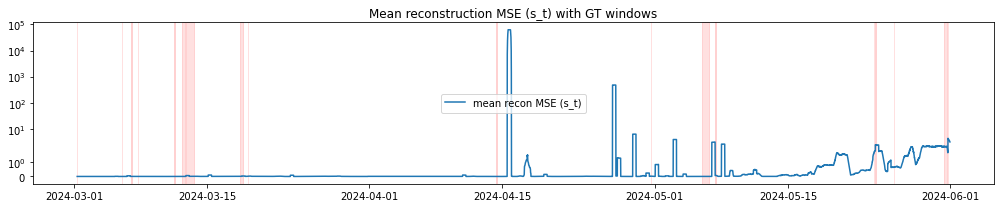

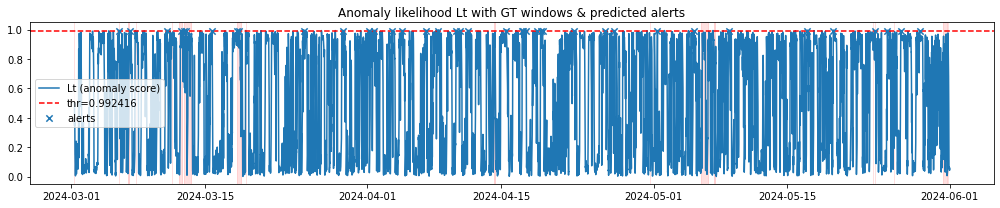


All figures saved to userData/pivoted_paper_autoformer_tf
All finished. Outputs saved in: userData/pivoted_paper_autoformer_tf


In [24]:
s_arr = np.asarray(all_rec_err).copy()    
L_raw_arr = np.asarray(L).copy()          
seq_timestamps = pd.to_datetime(timestamps)
try:
    seq_timestamps = seq_timestamps.tz_localize(None)
except Exception:
    pass
minlen = min(len(s_arr), len(L_raw_arr), len(seq_timestamps))
s_arr = s_arr[:minlen]
L_raw_arr = L_raw_arr[:minlen]
seq_timestamps = seq_timestamps[:minlen]

mse_series = pd.Series(s_arr, index=seq_timestamps)
lt_series  = pd.Series(L_raw_arr, index=seq_timestamps)


if ('df' in globals()) and ('sum_5xx_count' in df.columns):
    sum_5xx = df['sum_5xx_count'].loc[seq_timestamps[0]:seq_timestamps[-1]].fillna(0)
    sum_norm = (sum_5xx - sum_5xx.min()) / (sum_5xx.max() - sum_5xx.min() + 1e-12)
else:
    sum_norm = pd.Series([], dtype=float)


def ema(x, alpha):
    out = np.empty_like(x, dtype=float)
    acc = 0.0
    for i, v in enumerate(x):
        acc = alpha * v + (1 - alpha) * acc if i else v
        out[i] = acc
    return out

def shaped_alerts(Ls, thr, cd, k_of_m=(2,3)):
    k, m = k_of_m
    above = (Ls >= thr)
    n = len(above)
    persisted = np.zeros_like(above, dtype=bool)
    for i in range(n):
        persisted[i] = (above[max(0, i-m+1):i+1].sum() >= k)
    trig = np.zeros_like(above, dtype=bool)
    i = 0
    while i < n:
        if persisted[i]:
            trig[i] = True
            i += cd
        else:
            i += 1
    return trig


VAL_START, VAL_END = pd.Timestamp("2024-03-01"), pd.Timestamp("2024-03-15 23:59:59")
tidx_arr = np.array(seq_timestamps)
val_mask = (tidx_arr >= np.datetime64(VAL_START)) & (tidx_arr <= np.datetime64(VAL_END))
t_val = tidx_arr[val_mask]
gt_val = gt_in_test.copy()
if len(t_val)>0:
    gt_val = gt_val[(gt_val['anomaly_end'] >= pd.Timestamp(t_val[0])) & (gt_val['anomaly_start'] <= pd.Timestamp(t_val[-1]))].reset_index(drop=True)
else:
    gt_val = gt_val.iloc[0:0]

best = {"score": -1}
for alpha in [0.2, 0.3, 0.5]:
    Ls_try = ema(L_raw_arr, alpha)
    L_val = Ls_try[val_mask] if len(val_mask)>0 else np.array([])
    for k_of_m in [(2,3), (3,5)]:
        for cd in [12, 24, 36, 72]:
            for thr in np.linspace(0.992, 0.9999, 20):
                if len(L_val)==0:
                    continue
                pred_val = shaped_alerts(L_val, thr, cd, k_of_m)
                s, _ = nab_score_from_mask(pred_val, gt_val, pd.to_datetime(t_val), profile='standard', event_gap_minutes=cd, pct_prob=PCT_PROB)
                if s > best["score"]:
                    best = {"score": s, "alpha": alpha, "k_of_m": k_of_m, "cd": cd, "thr": thr}
if best["score"] < 0:
    best = {"alpha":0.3, "k_of_m":(2,3), "cd":24, "thr":PAPER_THR}

L_s = ema(L_raw_arr, best["alpha"])
pred_full_mask = shaped_alerts(L_s, best["thr"], best["cd"], best["k_of_m"])
pred_series_shaped = pd.Series(pred_full_mask.astype(int), index=seq_timestamps)
events_shaped = mask_to_event_times(pred_full_mask, seq_timestamps, event_gap_minutes=best["cd"], pct_prob=PCT_PROB)
scores_df_smoothed = pd.DataFrame({"timestamp": seq_timestamps, "anomaly_score": L_s}).set_index("timestamp")


fig2_path = os.path.join(OUT_DIR, 'fig2_5xx_distribution_autoformer_gru_style.png')
counts = df['sum_5xx_count'].fillna(0).values if ('df' in globals() and 'sum_5xx_count' in df.columns) else np.array([])
plt.figure(figsize=(6,4))
if len(counts)>0:
    min_x = max(1, counts.min()+1)
    max_x = counts.max()+1
    bins = np.logspace(max(0, np.log10(min_x)-0.1), np.log10(max_x)+0.1, 80)
    plt.hist(counts + 1e-9, bins=bins, histtype='step', linewidth=1.5)
    plt.xscale('log'); plt.yscale('log')
    mean_v = counts.mean(); median_v = np.median(counts)
    try:
        mode_v = stats.mode(counts)[0][0]
    except Exception:
        mode_v = np.nan
    plt.gca().text(0.95, 0.95, f"Mean: {mean_v:.2f}\nMedian: {median_v:.2f}\nMode: {mode_v:.2f}",
                   transform=plt.gca().transAxes, va='top', ha='right', bbox=dict(boxstyle='round', fc='white', alpha=0.8))
plt.title('Fig.2 — Distribution of request counts associated with 5XX errors')
plt.tight_layout(); plt.savefig(fig2_path, dpi=150); plt.show()
print("Saved Fig.2 ->", fig2_path)


fig3_path = os.path.join(OUT_DIR, 'fig3_sum5xx_norm_with_alerts_autoformer.png')
plt.figure(figsize=(12,3)); ax=plt.gca()
if not sum_norm.empty:
    ax.plot(sum_norm.index, sum_norm.values, label='Sum of 5XX Count (Normalized)', linewidth=1)

gt_to_draw = gt_in_test if 'gt_in_test' in globals() else (gt_df if 'gt_df' in globals() else None)
if gt_to_draw is not None and not gt_to_draw.empty:
    for _, r in gt_to_draw.iterrows():
        s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
        e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
        ax.axvspan(s,e,color='purple',alpha=0.12)

if len(events_shaped):
    ev_idx = pd.to_datetime(events_shaped)
    try:
        interp_vals = np.interp(ev_idx.astype('int64'), sum_norm.index.astype('int64'), sum_norm.values)
        plt.scatter(ev_idx, interp_vals, marker='x', color='red', s=40, label='Predicted Anomalies')
    except Exception:
        plt.scatter(ev_idx, [0]*len(ev_idx), marker='x', color='red', s=40, label='Predicted Anomalies')
plt.title('Fig.3 — Sum of 5XX Count (Normalized) with GT and Predicted Anomalies')
plt.legend(loc='upper right'); plt.tight_layout(); plt.savefig(fig3_path, dpi=150); plt.show()
print("Saved Fig.3 ->", fig3_path)


fig4_path = os.path.join(OUT_DIR, 'fig4_mar12_15_autoformer.png')
start4 = pd.Timestamp("2024-03-12"); end4 = pd.Timestamp("2024-03-15")
ix_sum = sum_norm.loc[start4:end4] if not sum_norm.empty else pd.Series([], dtype=float)
ix_mse = mse_series.loc[start4:end4] if not mse_series.empty else pd.Series([], dtype=float)
ix_lt  = lt_series.loc[start4:end4]  if not lt_series.empty else pd.Series([], dtype=float)
plt.figure(figsize=(12,4)); ax=plt.gca()
if not ix_sum.empty: ax.plot(ix_sum.index, ix_sum.values, label='5XX Count (Normalized)', linewidth=1)
if not ix_mse.empty: ax.plot(ix_mse.index, (ix_mse - ix_mse.min())/(ix_mse.max()-ix_mse.min()+1e-12), label='Reconstruction Error (Normalized)', linewidth=1)
if not ix_lt.empty:  ax.plot(ix_lt.index, ix_lt.values, label='Anomaly Likelihood (Lt)', linewidth=1)
ev_win = [e for e in events_shaped if (e >= start4) and (e <= end4)]
if len(ev_win) and not ix_lt.empty:
    vals = np.interp(pd.to_datetime(ev_win).astype('int64'), ix_lt.index.astype('int64'), ix_lt.values)
    plt.scatter(ev_win, vals, marker='x', color='red', s=50, label='Predicted Alerts')

if gt_to_draw is not None and not gt_to_draw.empty:
    ix_gt = gt_to_draw[(gt_to_draw['anomaly_start'] >= start4) & (gt_to_draw['anomaly_start'] <= end4)]
    for _, r in ix_gt.iterrows():
        s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
        e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
        ax.axvspan(s,e,color='purple',alpha=0.12)
plt.title('Fig.4 — Mar 12-15, 2024 example: 5XX, Recon Error, Likelihood'); plt.legend(); plt.tight_layout(); plt.savefig(fig4_path, dpi=150); plt.show()
print("Saved Fig.4 ->", fig4_path)


fig5_path = os.path.join(OUT_DIR, 'fig5_apr15_18_autoformer.png')
start5 = pd.Timestamp("2024-04-15"); end5 = pd.Timestamp("2024-04-18")
ix_sum = sum_norm.loc[start5:end5] if not sum_norm.empty else pd.Series([], dtype=float)
ix_mse = mse_series.loc[start5:end5] if not mse_series.empty else pd.Series([], dtype=float)
ix_lt  = lt_series.loc[start5:end5]  if not lt_series.empty else pd.Series([], dtype=float)
plt.figure(figsize=(12,4)); ax=plt.gca()
if not ix_sum.empty: ax.plot(ix_sum.index, ix_sum.values, label='5XX Count (Normalized)', linewidth=1)
if not ix_mse.empty: ax.plot(ix_mse.index, (ix_mse - ix_mse.min())/(ix_mse.max()-ix_mse.min()+1e-12), label='Reconstruction Error (Normalized)', linewidth=1)
if not ix_lt.empty:  ax.plot(ix_lt.index, ix_lt.values, label='Anomaly Likelihood (Lt)', linewidth=1)
ev_win = [e for e in events_shaped if (e >= start5) and (e <= end5)]
if len(ev_win) and not ix_lt.empty:
    vals = np.interp(pd.to_datetime(ev_win).astype('int64'), ix_lt.index.astype('int64'), ix_lt.values)
    plt.scatter(ev_win, vals, marker='x', color='red', s=50, label='Predicted Alerts')
if gt_to_draw is not None and not gt_to_draw.empty:
    ix_gt = gt_to_draw[(gt_to_draw['anomaly_start'] >= start5) & (gt_to_draw['anomaly_start'] <= end5)]
    for _, r in ix_gt.iterrows():
        s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
        e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
        ax.axvspan(s,e,color='purple',alpha=0.12)
plt.title('Fig.5 — Apr 15-18, 2024 example: detected abnormal behavior'); plt.legend(); plt.tight_layout(); plt.savefig(fig5_path, dpi=150); plt.show()
print("Saved Fig.5 ->", fig5_path)


try:
    plt.figure(figsize=(14,3))
    plt.plot(mse_series, label='mean recon MSE (s_t)')
    if gt_to_draw is not None and not gt_to_draw.empty:
        for _, r in gt_to_draw.iterrows():
            s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
            e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
            plt.axvspan(s,e,color='red', alpha=0.12)
    plt.yscale('symlog', linthresh=1e-6)
    plt.title('Mean reconstruction MSE (s_t) with GT windows'); plt.legend(); plt.tight_layout()
    plt.show()
except Exception as e:
    print('MSE plot error (ignored):', e)

try:
    plt.figure(figsize=(14,3))
    plt.plot(scores_df_smoothed.index, scores_df_smoothed['anomaly_score'], label='Lt (anomaly score)')
    plt.axhline(best["thr"], color='red', linestyle='--', label=f'thr={best["thr"]:.6f}')
    if gt_to_draw is not None and not gt_to_draw.empty:
        for _, r in gt_to_draw.iterrows():
            s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
            e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
            plt.axvspan(s, e, color='red', alpha=0.12)
    ev_dt = pd.to_datetime(events_shaped)
    if len(ev_dt):
        plt.scatter(ev_dt, [best["thr"]]*len(ev_dt), marker='x', s=40, label='alerts', zorder=5)
    plt.title('Anomaly likelihood Lt with GT windows & predicted alerts')
    plt.legend(); plt.tight_layout(); plt.show()
except Exception as e:
    print('Score plot error (ignored):', e)

print("\nAll figures saved to", OUT_DIR)
print('All finished. Outputs saved in:', OUT_DIR)